# Check data availibility MODIS

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
# sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# CICLAD
path = '/data/mlalande/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly/'
period = slice('2005','2008')

In [3]:
# For parallelisation
from dask.distributed import Client
client = Client(n_workers=64, threads_per_worker=1, memory_limit='4GB')
# client = Client()
client

<Client: 'tcp://127.0.0.1:35566' processes=64 threads=64, memory=256.00 GB>

In [8]:
client.close()

In [4]:
ds = xr.open_mfdataset(path+'*.nc', parallel=True, chunks={'lon': 1800, 'lat': 900}).sel(time=period)
ds

<xarray.Dataset>
Dimensions:          (lat: 18000, lon: 36000, time: 48)
Coordinates:
  * lat              (lat) float64 -90.0 -89.98 -89.97 ... 89.97 89.98 90.0
  * lon              (lon) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time             (time) datetime64[ns] 2005-01-31 2005-02-28 ... 2008-12-31
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(12, 900, 1800), meta=np.ndarray>
    coverage         (time, lat, lon) float64 dask.array<chunksize=(12, 900, 1800), meta=np.ndarray>
    coverage_interp  (time, lat, lon) float64 dask.array<chunksize=(12, 900, 1800), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(12, 900, 1800), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(12, 900, 1800), meta=np.ndarray>
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                ENVEO IT GmbH
    source:                     TERRA MODIS, Collection 6.1: calibrated radia...
    history:                    2021-12-03: ESA snow_cci processing line SCFG...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                071766fd-d627-4051-81c7-4c54e4f4b8f8
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3, 2021
    summary:                    The SCF product provides daily information on...
    keywords:                   snow cover, MODIS, TERRA
    id:                         20000224-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2...
    naming_authority:           at.enveo
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Swath
    comment:                    The following auxiliary data sets are used fo...
    date_created:               2021-11-18 00:22:17Z
    creator_name:               ENVEO IT GmbH
    creator_url:                http://www.enveo.at/
    creator_email:              snowcci@enveo.at
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.01
    geospatial_lat_resolution:  0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        20000224T000000Z
    time_coverage_end:          20000224T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   TERRA
    sensor:                     MODIS
    spatial_resolution:         0.01 degree
    key_variables:              scfg
    doi:                        10.5285/8847a05eeda646a29da58b42bdf2a87c

In [5]:
ds.scfg_interp

<xarray.DataArray 'scfg_interp' (time: 48, lat: 18000, lon: 36000)>
dask.array<getitem, shape=(48, 18000, 36000), dtype=float64, chunksize=(12, 900, 1800), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.98 -89.97 -89.97 ... 89.97 89.97 89.98 90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2005-01-31 2005-02-28 ... 2008-12-31

In [7]:
# ds.scfg_interp[0].plot()

In [8]:
# ds.coverage[0].plot()

In [5]:
# Zones
latlim_SA = slice(-60, -10); lonlim_SA = slice(-80, -60)
latlim_US = slice(20, 70); lonlim_US = slice(-165, -85)
latlim_EU = slice(30, 80); lonlim_EU = slice(0, 20)
latlim_HMA = slice(20, 55); lonlim_HMA = slice(60, 116)

In [7]:
%%time
coverage_all = ds.coverage.sum('time').where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ) / \
                    (pd.to_datetime(str(int(period.stop)+1)) - pd.to_datetime(period.start)).days * 100
coverage_all.load()

CPU times: user 5min 2s, sys: 1min 3s, total: 6min 6s
Wall time: 10min 32s


<xarray.DataArray 'coverage' (lat: 18000, lon: 36000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.98 -89.97 -89.97 ... 89.97 89.97 89.98 90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    time     datetime64[ns] 2005-01-31

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


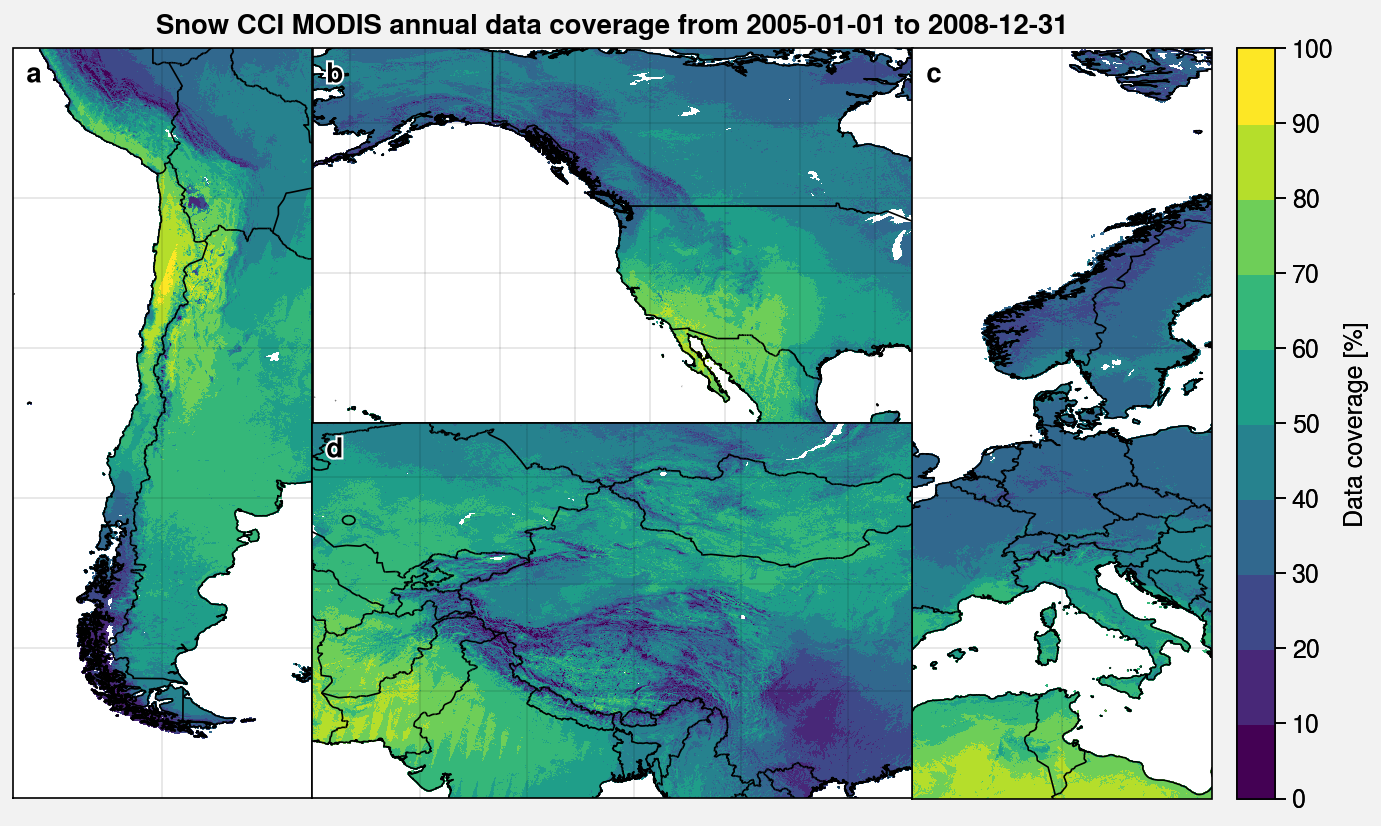

In [28]:
fig, axs = plot.subplots([[1, 2, 2, 3], [1, 4, 4, 3]], proj='cyl', space=0, axwidth=1.5)

da = coverage_all
cmap = 'viridis'
levels = plot.arange(0, 100, 10)

m = axs[0].pcolormesh(da.sel(lat=latlim_SA, lon=lonlim_SA), cmap=cmap, levels=levels)
axs[0].format(latlim=(latlim_SA.start, latlim_SA.stop), lonlim=(lonlim_SA.start, lonlim_SA.stop))

axs[1].pcolormesh(da.sel(lat=latlim_US, lon=lonlim_US), cmap=cmap, levels=levels)
axs[1].format(latlim=(latlim_US.start, latlim_US.stop), lonlim=(lonlim_US.start, lonlim_US.stop))

axs[2].pcolormesh(da.sel(lat=latlim_EU, lon=lonlim_EU), cmap=cmap, levels=levels)
axs[2].format(latlim=(latlim_EU.start, latlim_EU.stop), lonlim=(lonlim_EU.start, lonlim_EU.stop))

axs[3].pcolormesh(da.sel(lat=latlim_HMA, lon=lonlim_HMA), cmap=cmap, levels=levels)
axs[3].format(latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop))

fig.colorbar(m, label='Data coverage [%]', ticks=10)

axs.format(
    lonlines=10, latlines=10,
    suptitle='Snow CCI MODIS annual data coverage from '+str(pd.to_datetime(period.start))[:10]+ ' to '+str(ds.time[-1].values)[:10],
    coast=True, borders=True,
#     ocean=True, oceancolor='pale blue',
    abc=True, abcloc='ul', reso='hi'
)

fig.save('img/snowCCI_MODIS_annual_coverage_'+str(pd.to_datetime(period.start))[:10]+'_'+str(ds.time[-1].values)[:10]+'.jpg')

In [8]:
%%time
coverage_interp_all = ds.coverage_interp.sum('time').where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ) / \
                    (pd.to_datetime(str(int(period.stop)+1)) - pd.to_datetime(period.start)).days * 100
coverage_interp_all.load()

CPU times: user 4min 33s, sys: 59.9 s, total: 5min 33s
Wall time: 10min 1s


<xarray.DataArray 'coverage_interp' (lat: 18000, lon: 36000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.98 -89.97 -89.97 ... 89.97 89.97 89.98 90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    time     datetime64[ns] 2005-01-31

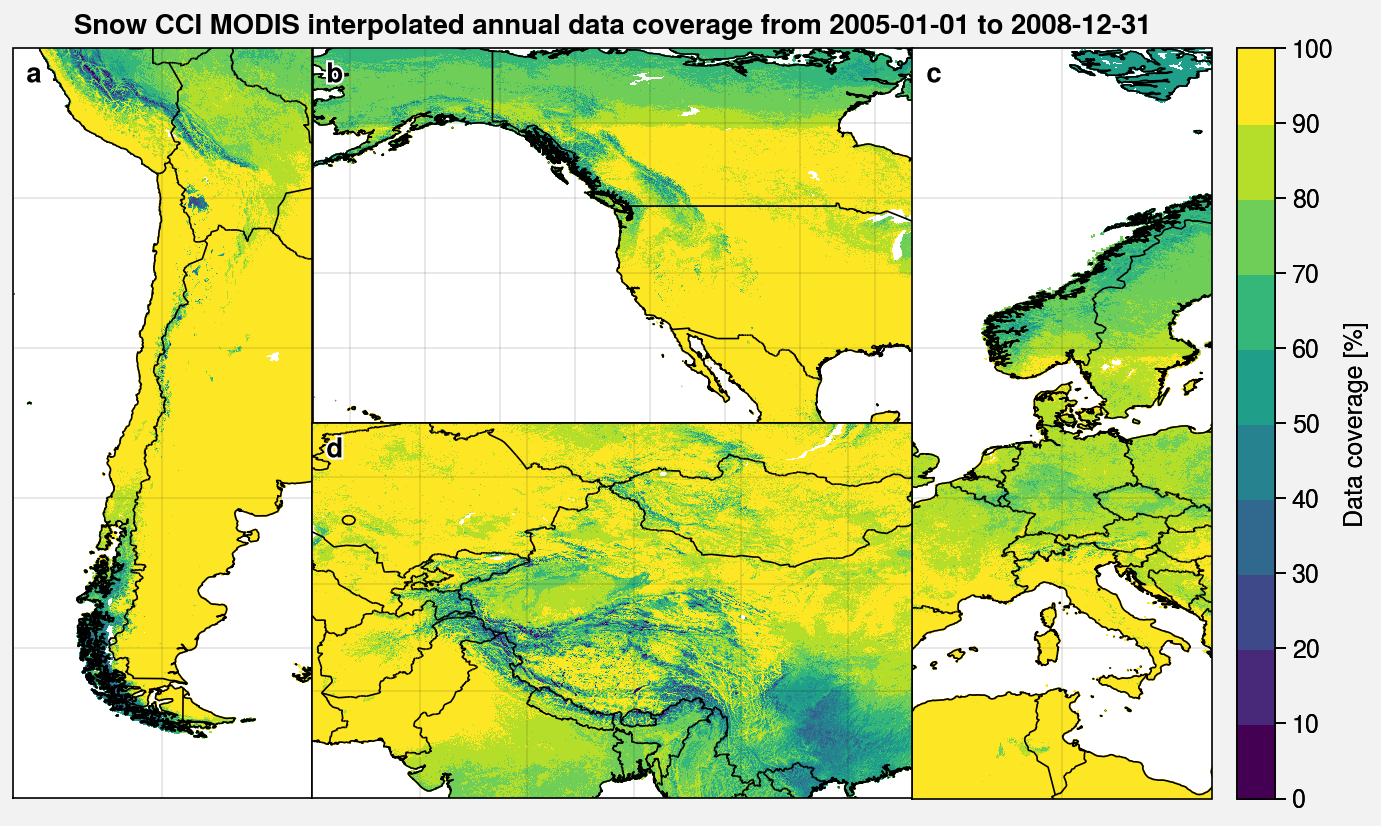

In [9]:
fig, axs = plot.subplots([[1, 2, 2, 3], [1, 4, 4, 3]], proj='cyl', space=0, axwidth=1.5)

da = coverage_interp_all
cmap = 'viridis'
levels = plot.arange(0, 100, 10)

m = axs[0].pcolormesh(da.sel(lat=latlim_SA, lon=lonlim_SA), cmap=cmap, levels=levels)
axs[0].format(latlim=(latlim_SA.start, latlim_SA.stop), lonlim=(lonlim_SA.start, lonlim_SA.stop))

axs[1].pcolormesh(da.sel(lat=latlim_US, lon=lonlim_US), cmap=cmap, levels=levels)
axs[1].format(latlim=(latlim_US.start, latlim_US.stop), lonlim=(lonlim_US.start, lonlim_US.stop))

axs[2].pcolormesh(da.sel(lat=latlim_EU, lon=lonlim_EU), cmap=cmap, levels=levels)
axs[2].format(latlim=(latlim_EU.start, latlim_EU.stop), lonlim=(lonlim_EU.start, lonlim_EU.stop))

axs[3].pcolormesh(da.sel(lat=latlim_HMA, lon=lonlim_HMA), cmap=cmap, levels=levels)
axs[3].format(latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop))

fig.colorbar(m, label='Data coverage [%]', ticks=10)

axs.format(
    lonlines=10, latlines=10,
    suptitle='Snow CCI MODIS interpolated annual data coverage from '+str(pd.to_datetime(period.start))[:10]+ ' to '+str(ds.time[-1].values)[:10],
    coast=True, borders=True,
#     ocean=True, oceancolor='pale blue',
    abc=True, abcloc='ul', reso='hi'
)

fig.save('img/snowCCI_MODIS_interp_annual_coverage_'+str(pd.to_datetime(period.start))[:10]+'_'+str(ds.time[-1].values)[:10]+'.jpg')

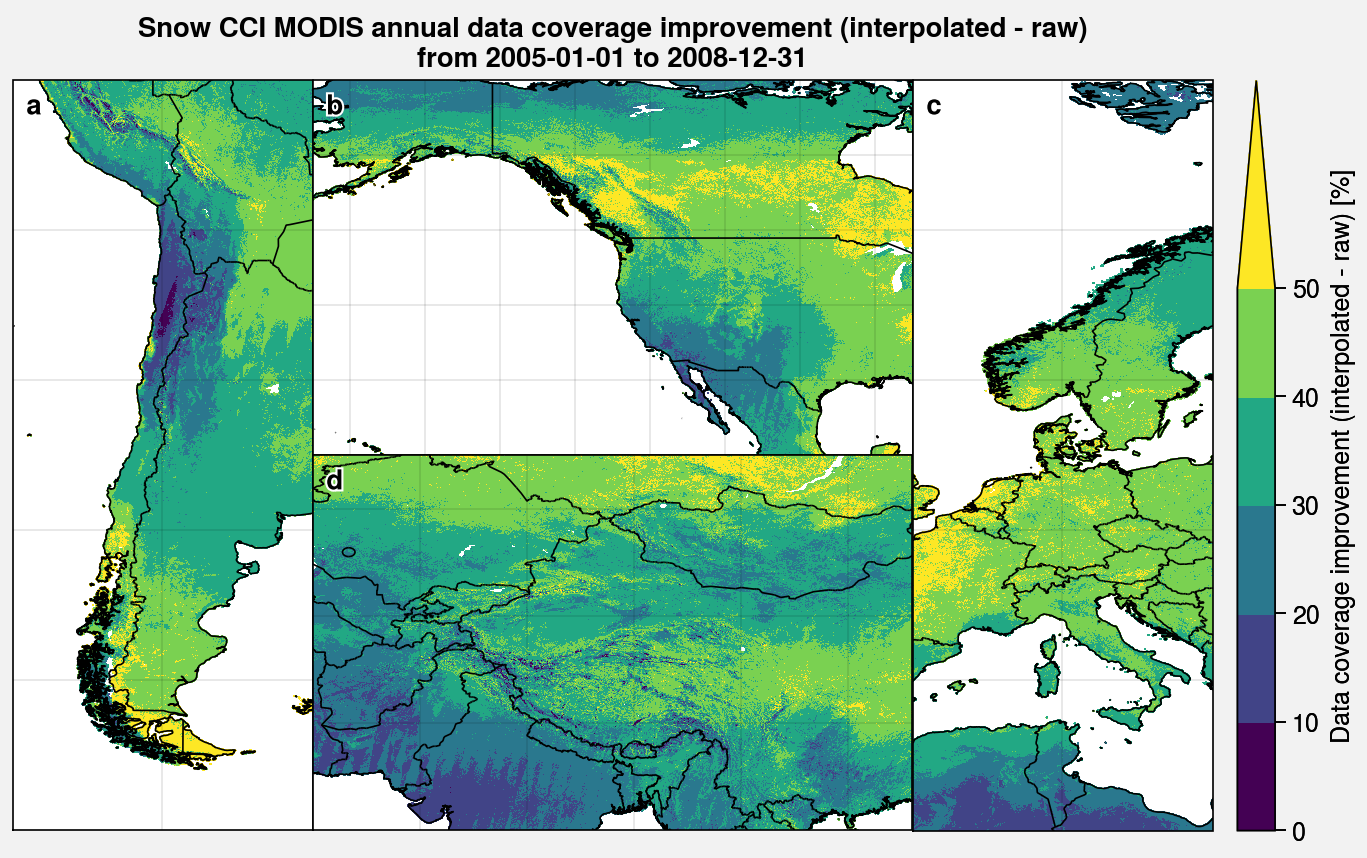

In [10]:
fig, axs = plot.subplots([[1, 2, 2, 3], [1, 4, 4, 3]], proj='cyl', space=0, axwidth=1.5)

da = coverage_interp_all - coverage_all
cmap = 'viridis'
levels = plot.arange(0, 50, 10)
extend = 'max'

m = axs[0].pcolormesh(da.sel(lat=latlim_SA, lon=lonlim_SA), cmap=cmap, levels=levels, extend=extend)
axs[0].format(latlim=(latlim_SA.start, latlim_SA.stop), lonlim=(lonlim_SA.start, lonlim_SA.stop))

axs[1].pcolormesh(da.sel(lat=latlim_US, lon=lonlim_US), cmap=cmap, levels=levels, extend=extend)
axs[1].format(latlim=(latlim_US.start, latlim_US.stop), lonlim=(lonlim_US.start, lonlim_US.stop))

axs[2].pcolormesh(da.sel(lat=latlim_EU, lon=lonlim_EU), cmap=cmap, levels=levels, extend=extend)
axs[2].format(latlim=(latlim_EU.start, latlim_EU.stop), lonlim=(lonlim_EU.start, lonlim_EU.stop))

axs[3].pcolormesh(da.sel(lat=latlim_HMA, lon=lonlim_HMA), cmap=cmap, levels=levels, extend=extend)
axs[3].format(latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop))

fig.colorbar(m, label='Data coverage improvement (interpolated - raw) [%]', ticks=10)

axs.format(
    lonlines=10, latlines=10,
    suptitle='Snow CCI MODIS annual data coverage improvement (interpolated - raw)\nfrom '+str(pd.to_datetime(period.start))[:10]+ ' to '+str(ds.time[-1].values)[:10],
    coast=True, borders=True,
#     ocean=True, oceancolor='pale blue',
    abc=True, abcloc='ul', reso='hi'
)

fig.save('img/snowCCI_MODIS_improv_annual_coverage_'+str(pd.to_datetime(period.start))[:10]+'_'+str(ds.time[-1].values)[:10]+'.jpg')

## By seasons
Only HMA cause too heavy

In [7]:
ts = pd.date_range(pd.to_datetime(period.start), ds.time[-1].values, freq='D').to_series().resample('M').count()

n_days_seas = np.array([
    ts.where( (ts.index.month >= 9) & (ts.index.month <= 11) ).sum(),
    ts.where( (ts.index.month >= 12) | (ts.index.month <= 2) ).sum(),
    ts.where( (ts.index.month >= 3) & (ts.index.month <= 5) ).sum(),
    ts.where( (ts.index.month >= 6) & (ts.index.month <= 8) ).sum(),
])
n_days_seas

array([364., 361., 368., 368.])

In [8]:
%%time
coverage_seas = ds.sel(lat=latlim_HMA, lon=lonlim_HMA).coverage.groupby('time.season').sum('time').where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) )
coverage_seas.load()

coverage_interp_seas = ds.sel(lat=latlim_HMA, lon=lonlim_HMA).coverage_interp.groupby('time.season').sum('time').where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) )
coverage_interp_seas.load()

CPU times: user 27.9 s, sys: 7.05 s, total: 35 s
Wall time: 1min 1s


<xarray.DataArray 'coverage_interp' (season: 4, lat: 3500, lon: 5600)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [298., 298., 301., ..., 334., 334., 339.],
        [298., 298., 298., ..., 269., 257., 242.],
        [298., 298., 299., ..., 334., 334., 287.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [329., 329., 342., ..., 362., 362., 368.],
        [330., 334., 342., ..., 368., 368., 368.],
        [352., 331., 342., ..., 368., 368., 368.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [332., 332., 358., ..., 321., 312., 327.],
        [335., 335., 326., ..., 309., 289., 285.],
        [315., 315., 331., ..., 351., 305., 303.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [330., 330., 330., ..., 332., 337., 352.],
        [334., 334., 324., ..., 333., 320., 317.],
        [324., 324., 324., ..., 319., 319., 307.]]])
Coordinates:
  * lat      (lat) float64 20.0 20.02 20.02 20.04 ... 54.97 54.98 54.98 54.99
  * lon      (lon) float64 60.01 60.02 60.02 60.03 ... 116.0 116.0 116.0 116.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
    time     datetime64[ns] 2005-01-31

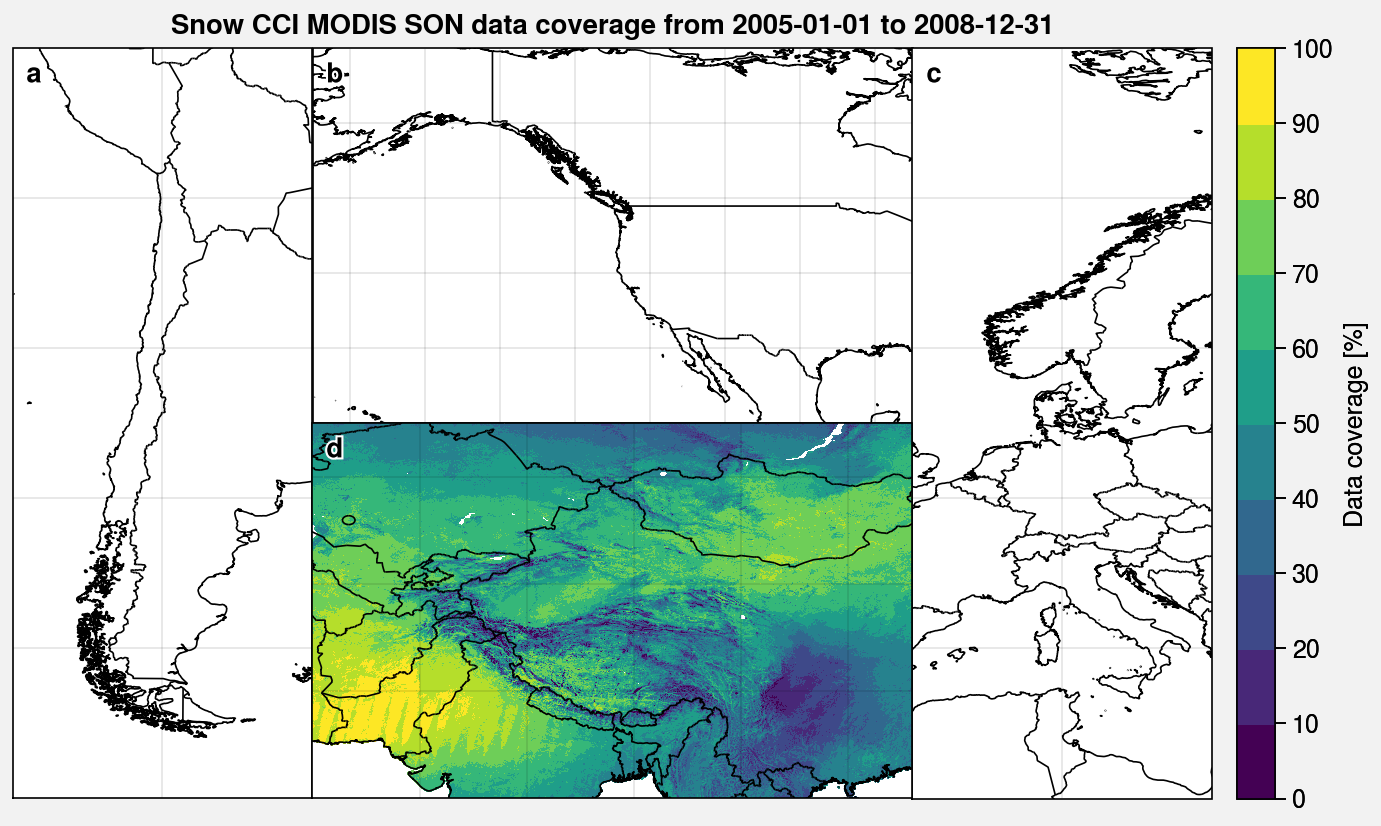

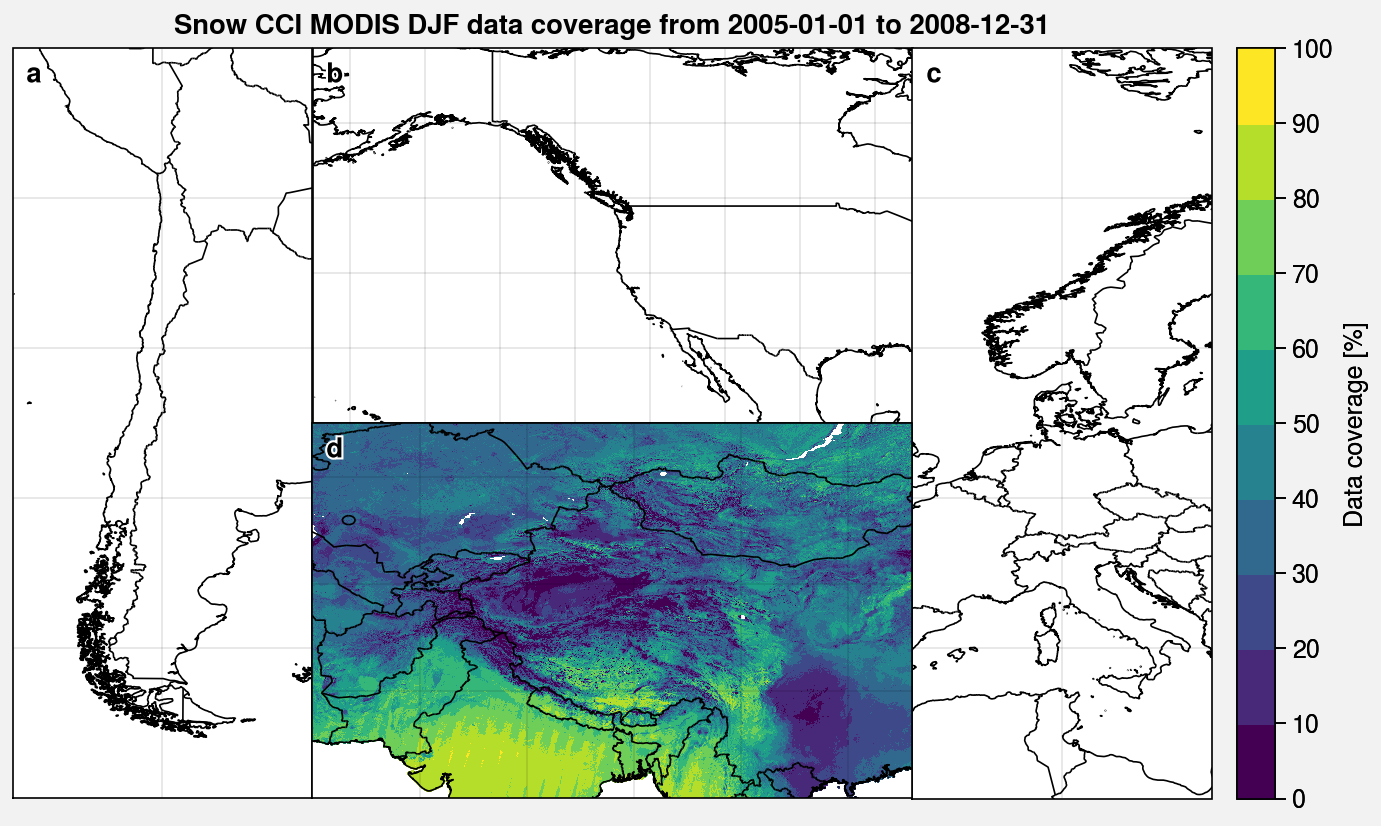

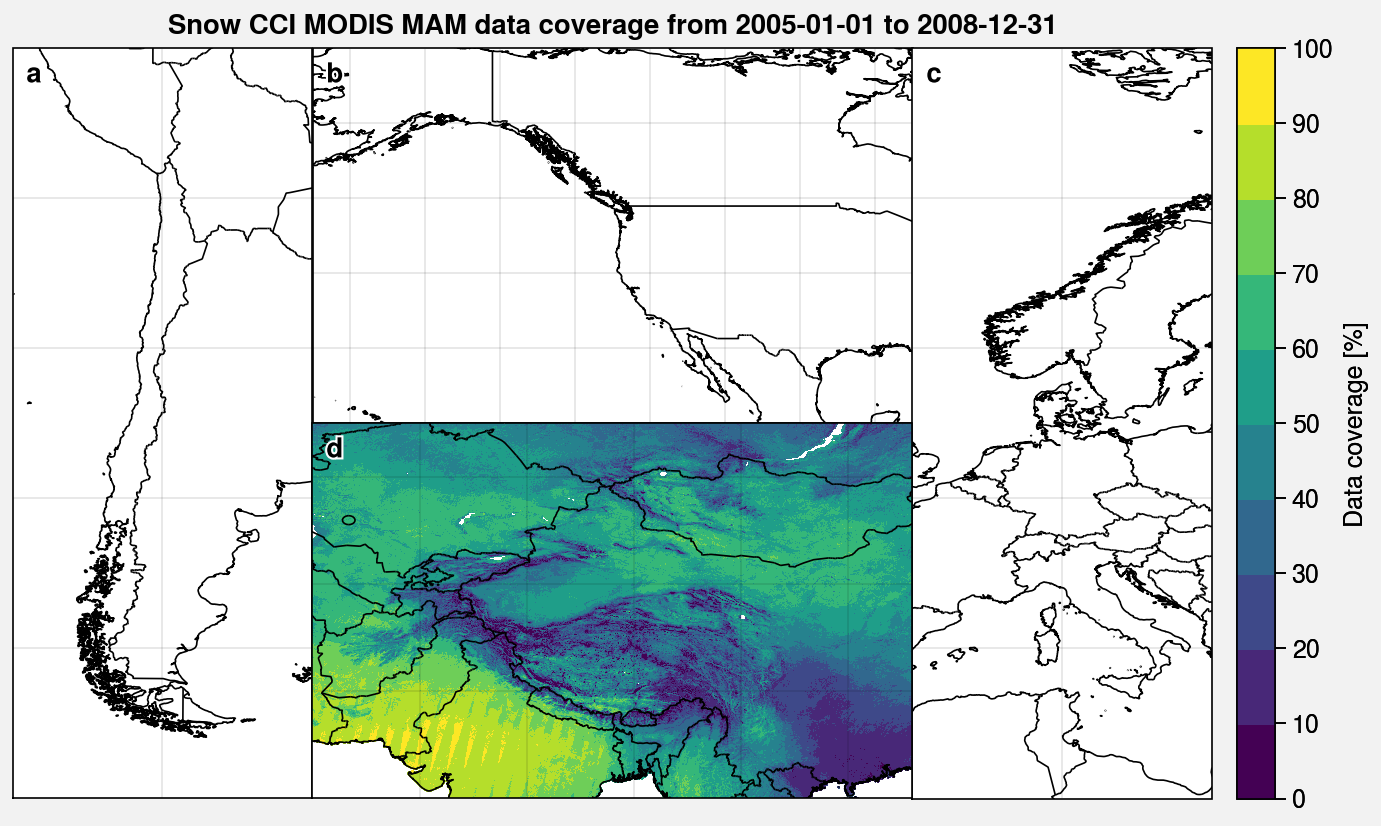

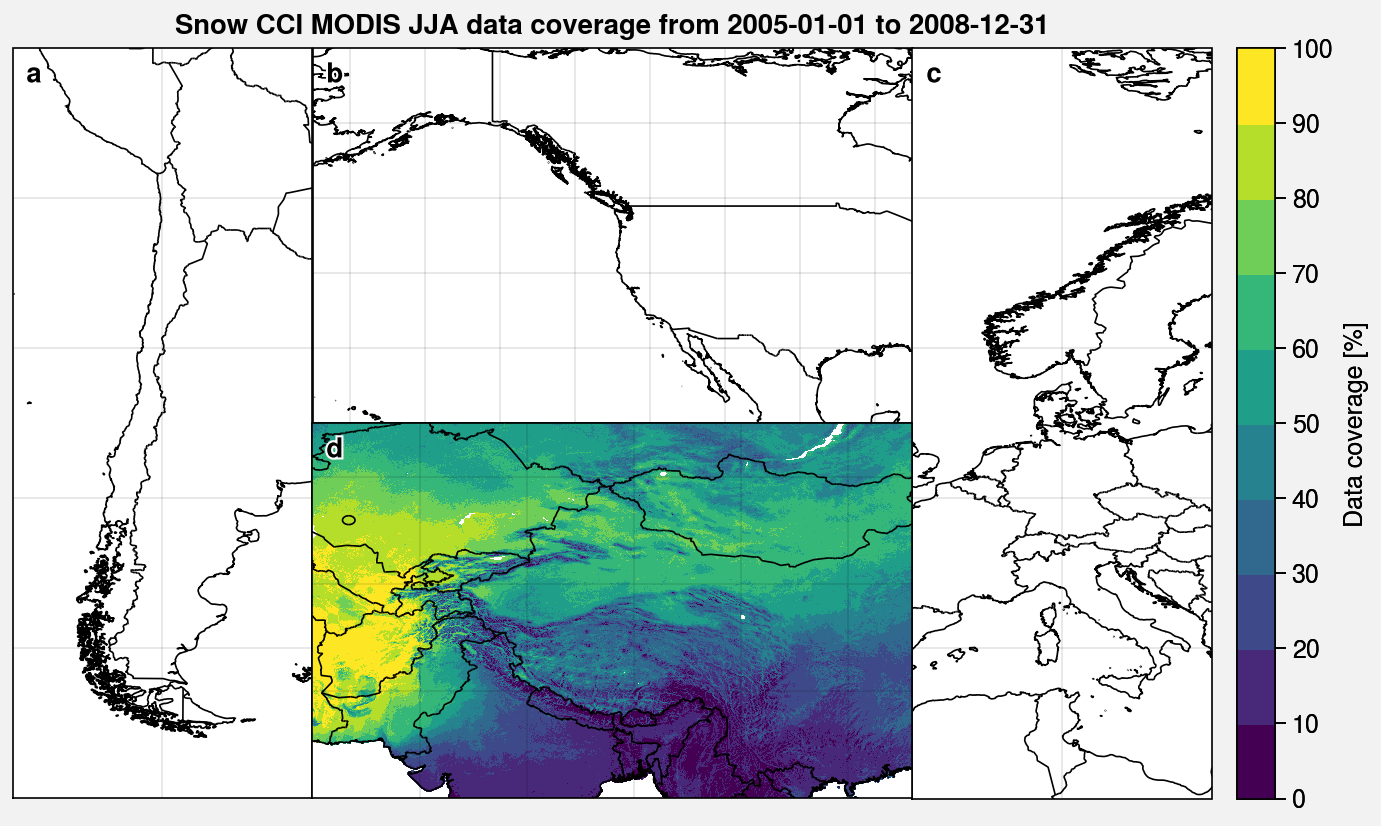

In [9]:
for i, season in enumerate(['SON', 'DJF', 'MAM', 'JJA']):

    fig, axs = plot.subplots([[1, 2, 2, 3], [1, 4, 4, 3]], proj='cyl', space=0, axwidth=1.5)

    da = coverage_seas.sel(season=season) / n_days_seas[i] * 100
    cmap = 'viridis'
    levels = plot.arange(0, 100, 10)

#     m = axs[0].pcolormesh(da.sel(lat=latlim_SA, lon=lonlim_SA), cmap=cmap, levels=levels)
    axs[0].format(latlim=(latlim_SA.start, latlim_SA.stop), lonlim=(lonlim_SA.start, lonlim_SA.stop))

#     axs[1].pcolormesh(da.sel(lat=latlim_US, lon=lonlim_US), cmap=cmap, levels=levels)
    axs[1].format(latlim=(latlim_US.start, latlim_US.stop), lonlim=(lonlim_US.start, lonlim_US.stop))

#     axs[2].pcolormesh(da.sel(lat=latlim_EU, lon=lonlim_EU), cmap=cmap, levels=levels)
    axs[2].format(latlim=(latlim_EU.start, latlim_EU.stop), lonlim=(lonlim_EU.start, lonlim_EU.stop))

    m = axs[3].pcolormesh(da.sel(lat=latlim_HMA, lon=lonlim_HMA), cmap=cmap, levels=levels)
    axs[3].format(latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop))

    fig.colorbar(m, label='Data coverage [%]', ticks=10)

    axs.format(
        lonlines=10, latlines=10,
        suptitle='Snow CCI MODIS '+season+' data coverage from '+str(pd.to_datetime(period.start))[:10]+ ' to '+str(ds.time[-1].values)[:10],
        coast=True, borders=True,
    #     ocean=True, oceancolor='pale blue',
        abc=True, abcloc='ul', reso='hi'
    )
    
    fig.save('img/snowCCI_MODIS_'+season+'_coverage_'+str(pd.to_datetime(period.start))[:10]+'_'+str(ds.time[-1].values)[:10]+'.jpg')

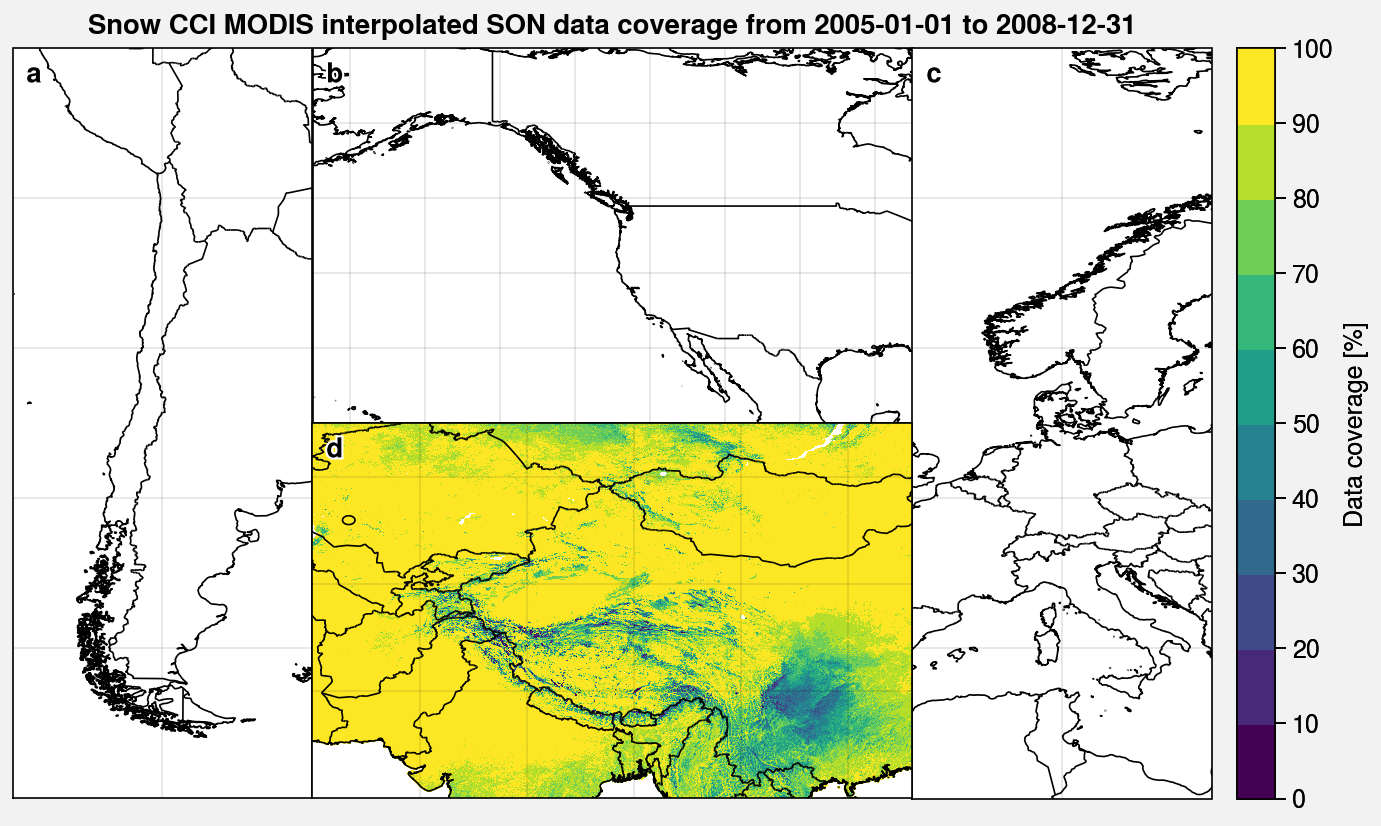

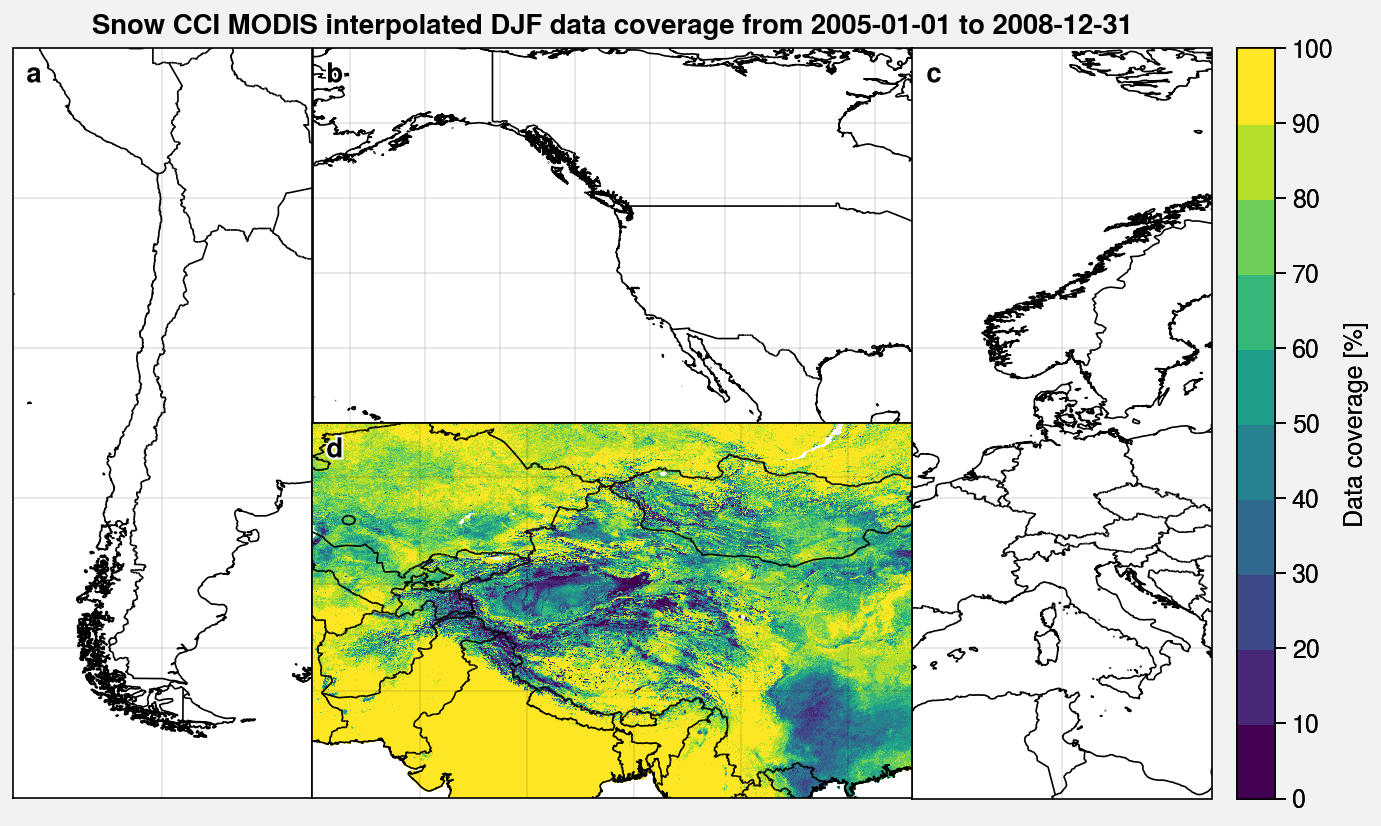

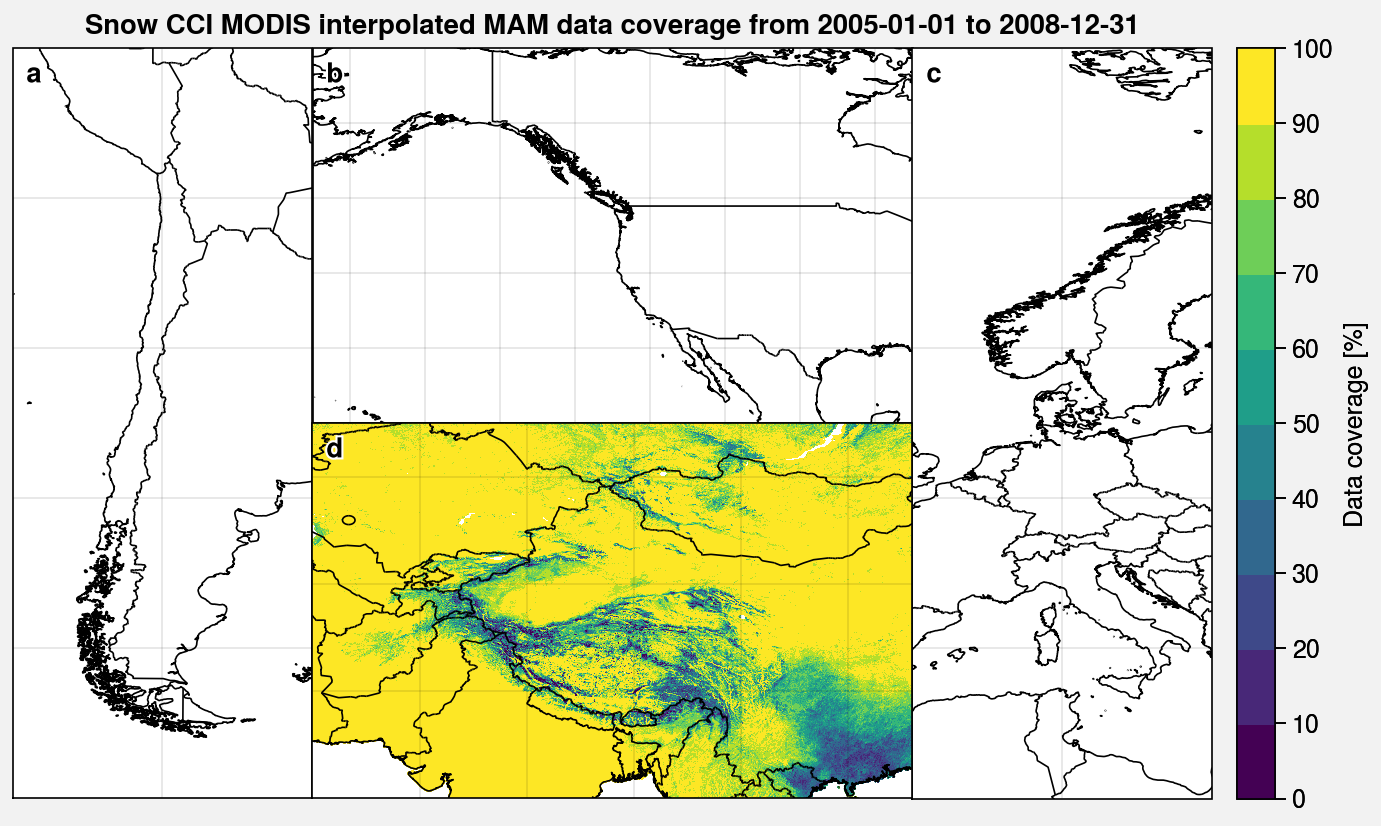

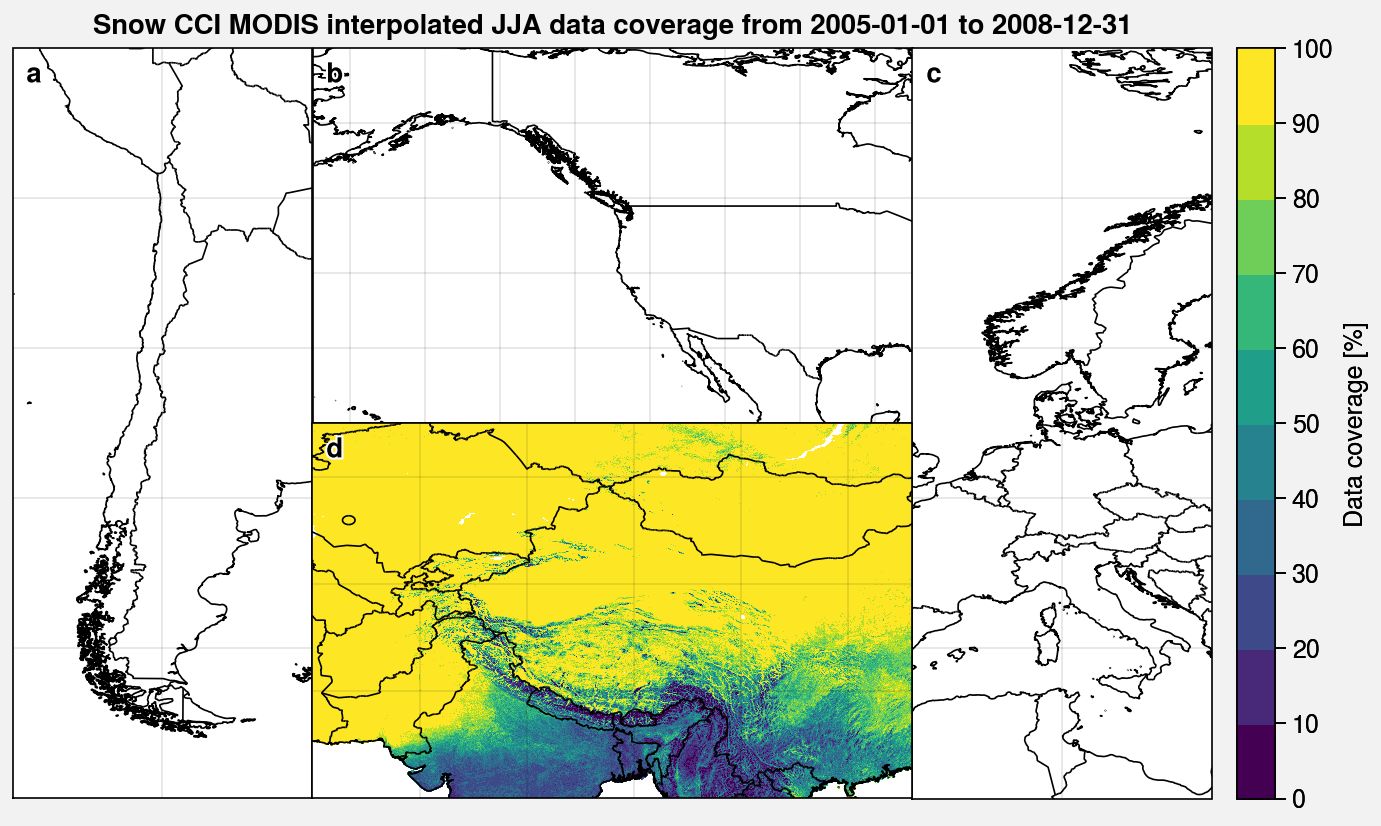

In [10]:
for i, season in enumerate(['SON', 'DJF', 'MAM', 'JJA']):

    fig, axs = plot.subplots([[1, 2, 2, 3], [1, 4, 4, 3]], proj='cyl', space=0, axwidth=1.5)

    da = coverage_interp_seas.sel(season=season) / n_days_seas[i] * 100
    cmap = 'viridis'
    levels = plot.arange(0, 100, 10)

#     m = axs[0].pcolormesh(da.sel(lat=latlim_SA, lon=lonlim_SA), cmap=cmap, levels=levels)
    axs[0].format(latlim=(latlim_SA.start, latlim_SA.stop), lonlim=(lonlim_SA.start, lonlim_SA.stop))

#     axs[1].pcolormesh(da.sel(lat=latlim_US, lon=lonlim_US), cmap=cmap, levels=levels)
    axs[1].format(latlim=(latlim_US.start, latlim_US.stop), lonlim=(lonlim_US.start, lonlim_US.stop))

#     axs[2].pcolormesh(da.sel(lat=latlim_EU, lon=lonlim_EU), cmap=cmap, levels=levels)
    axs[2].format(latlim=(latlim_EU.start, latlim_EU.stop), lonlim=(lonlim_EU.start, lonlim_EU.stop))

    m = axs[3].pcolormesh(da.sel(lat=latlim_HMA, lon=lonlim_HMA), cmap=cmap, levels=levels)
    axs[3].format(latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop))

    fig.colorbar(m, label='Data coverage [%]', ticks=10)

    axs.format(
        lonlines=10, latlines=10,
        suptitle='Snow CCI MODIS interpolated '+season+' data coverage from '+str(pd.to_datetime(period.start))[:10]+ ' to '+str(ds.time[-1].values)[:10],
        coast=True, borders=True,
    #     ocean=True, oceancolor='pale blue',
        abc=True, abcloc='ul', reso='hi'
    )
    
    fig.save('img/snowCCI_MODIS_interp_'+season+'_coverage_'+str(pd.to_datetime(period.start))[:10]+'_'+str(ds.time[-1].values)[:10]+'.jpg')    

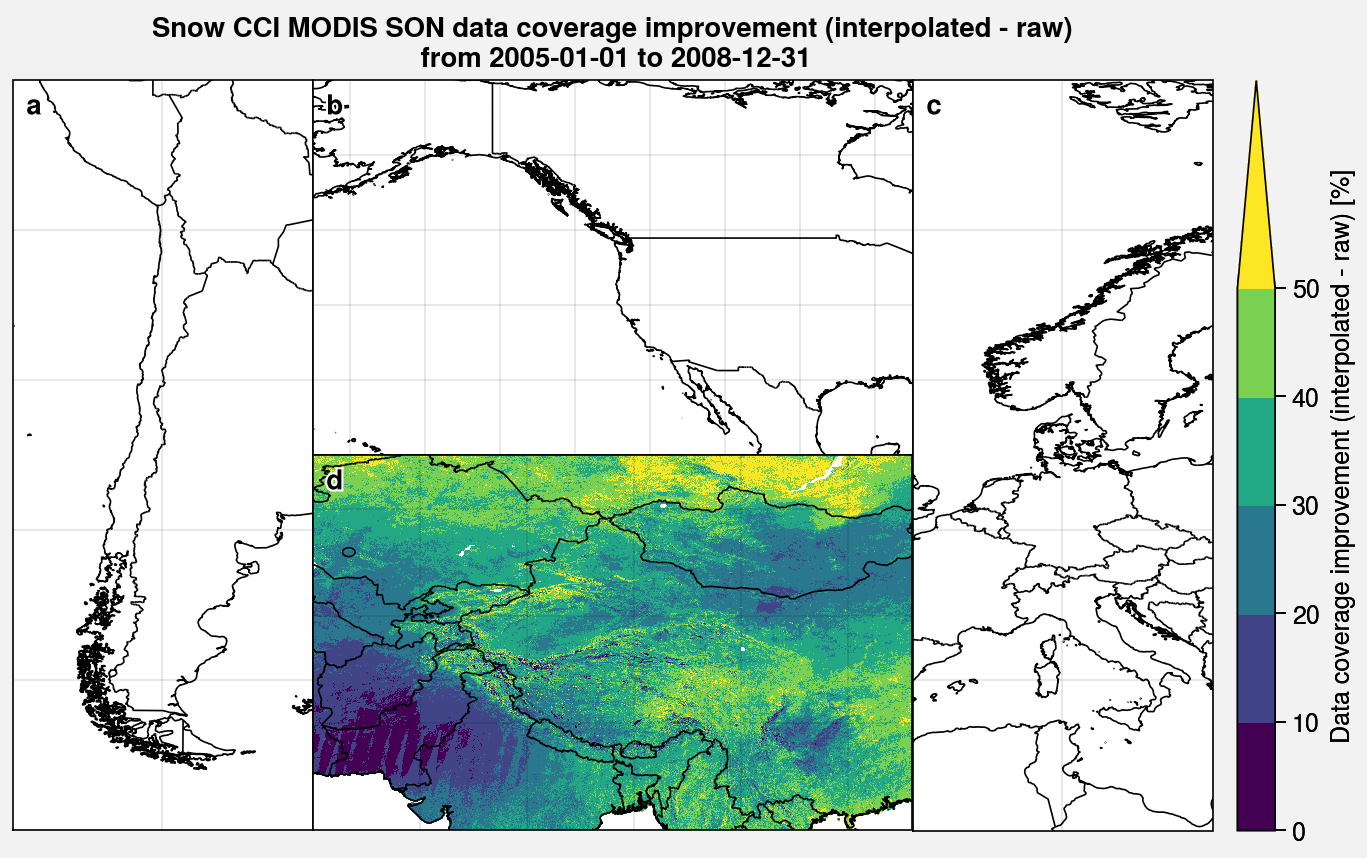

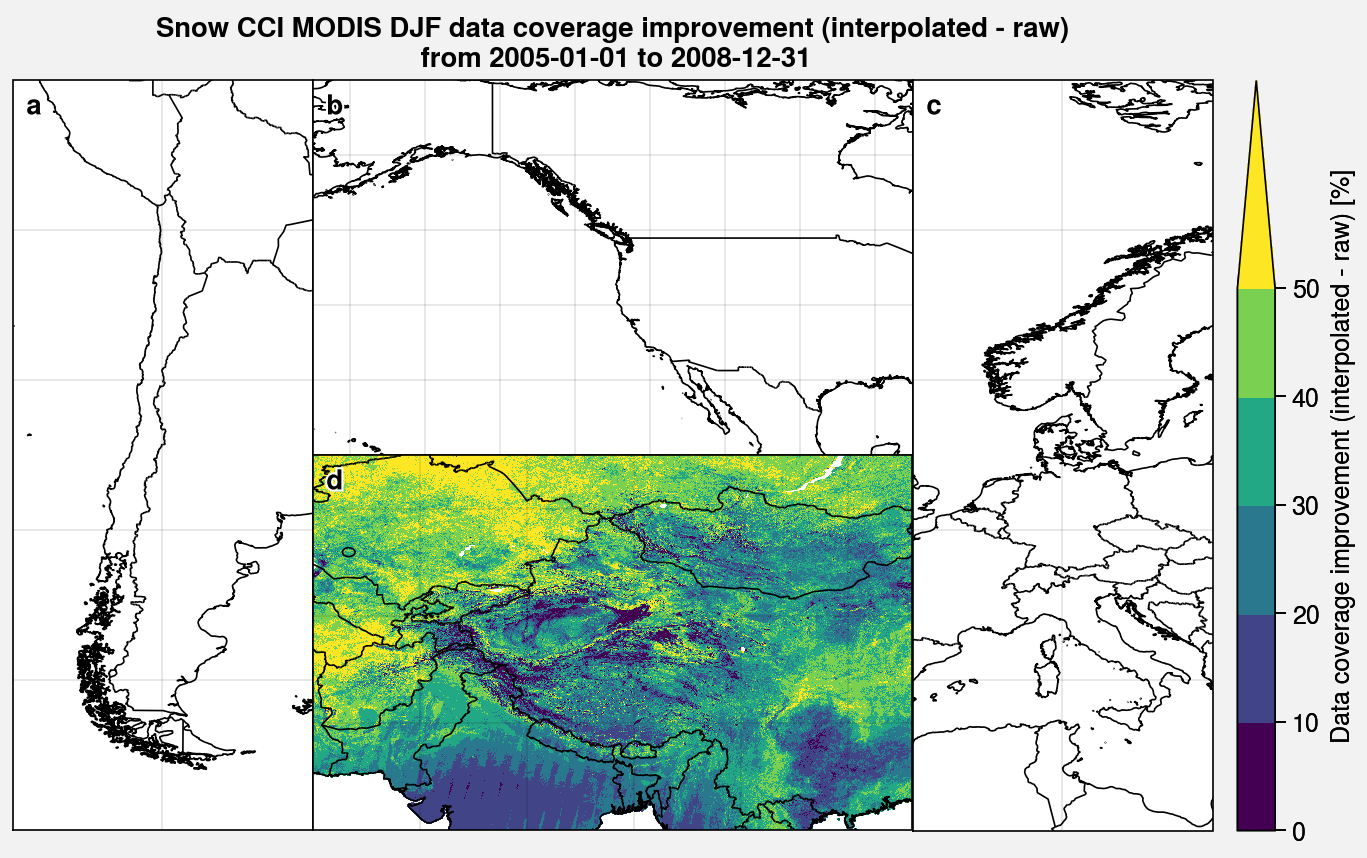

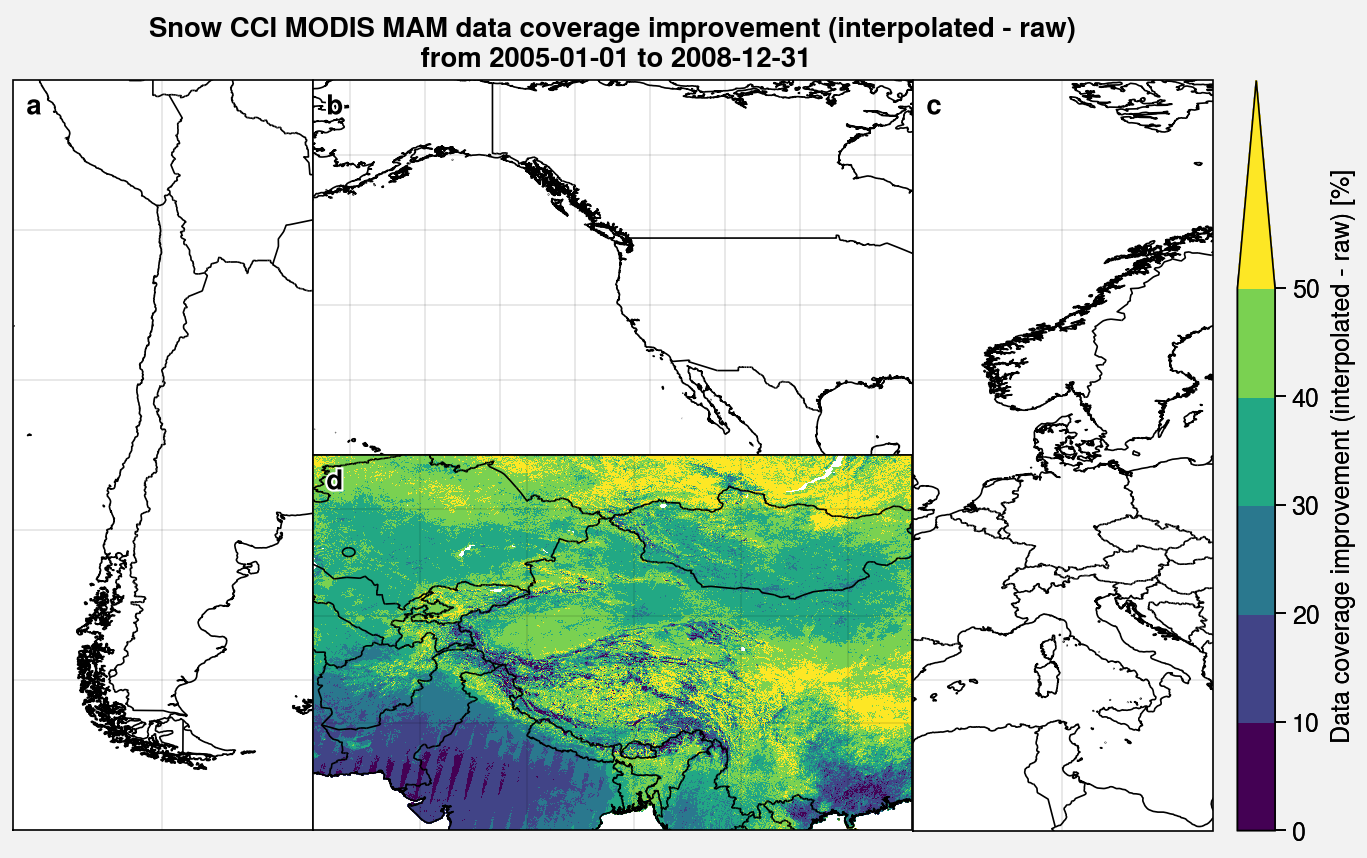

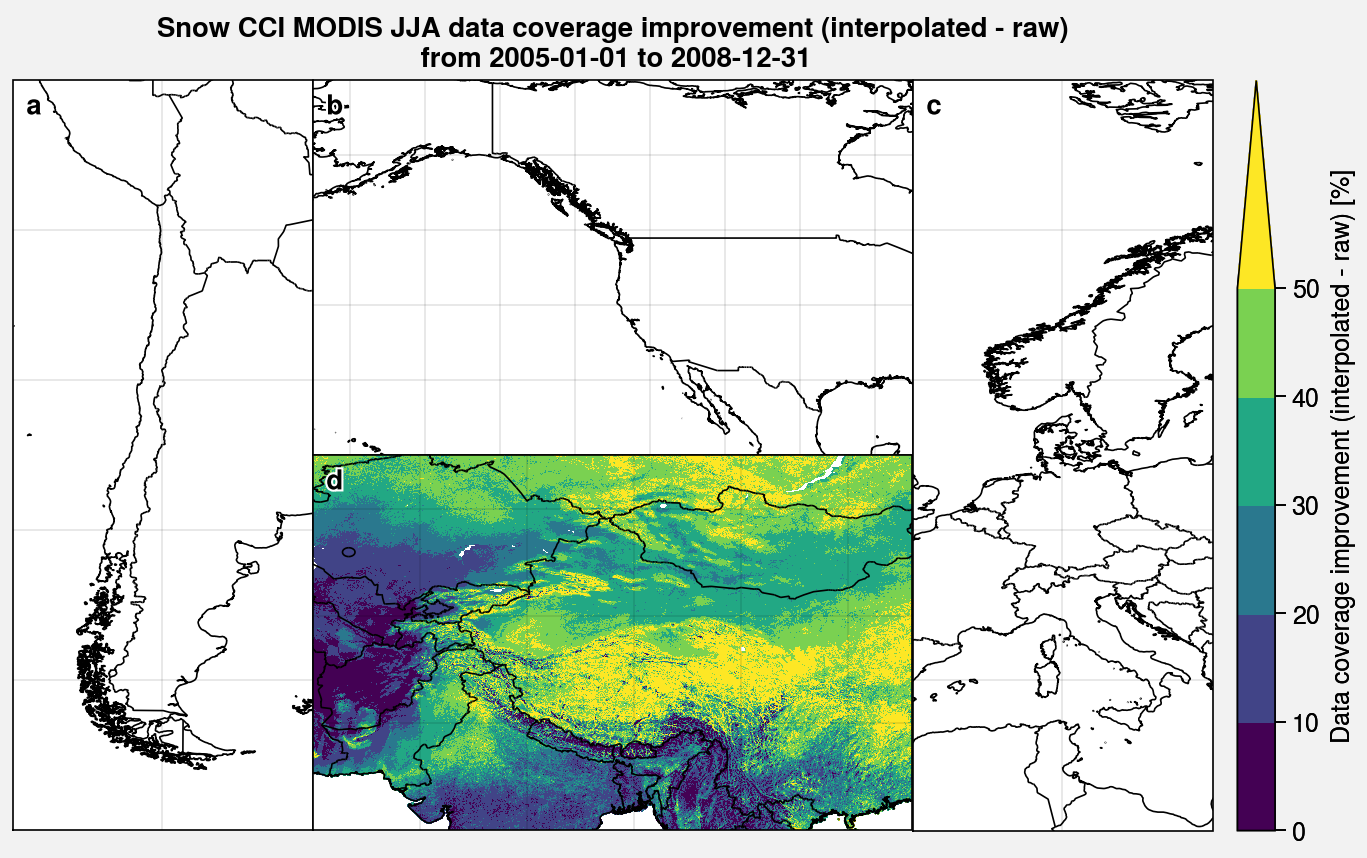

In [11]:
for i, season in enumerate(['SON', 'DJF', 'MAM', 'JJA']):

    fig, axs = plot.subplots([[1, 2, 2, 3], [1, 4, 4, 3]], proj='cyl', space=0, axwidth=1.5)

    da = ( coverage_interp_seas.sel(season=season) - coverage_seas.sel(season=season) ) / n_days_seas[i] * 100
    cmap = 'viridis'
    levels = plot.arange(0, 50, 10)
    extend = 'max'

#     m = axs[0].pcolormesh(da.sel(lat=latlim_SA, lon=lonlim_SA), cmap=cmap, levels=levels, extend=extend)
    axs[0].format(latlim=(latlim_SA.start, latlim_SA.stop), lonlim=(lonlim_SA.start, lonlim_SA.stop))

#     axs[1].pcolormesh(da.sel(lat=latlim_US, lon=lonlim_US), cmap=cmap, levels=levels, extend=extend)
    axs[1].format(latlim=(latlim_US.start, latlim_US.stop), lonlim=(lonlim_US.start, lonlim_US.stop))

#     axs[2].pcolormesh(da.sel(lat=latlim_EU, lon=lonlim_EU), cmap=cmap, levels=levels, extend=extend)
    axs[2].format(latlim=(latlim_EU.start, latlim_EU.stop), lonlim=(lonlim_EU.start, lonlim_EU.stop))

    m = axs[3].pcolormesh(da.sel(lat=latlim_HMA, lon=lonlim_HMA), cmap=cmap, levels=levels, extend=extend)
    axs[3].format(latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop))

    fig.colorbar(m, label='Data coverage improvement (interpolated - raw) [%]', ticks=10)

    axs.format(
        lonlines=10, latlines=10,
        suptitle='Snow CCI MODIS '+season+' data coverage improvement (interpolated - raw)\n from '+str(pd.to_datetime(period.start))[:10]+ ' to '+str(ds.time[-1].values)[:10],
        coast=True, borders=True,
    #     ocean=True, oceancolor='pale blue',
        abc=True, abcloc='ul', reso='hi'
    )
    
    fig.save('img/snowCCI_MODIS_improv_'+season+'_coverage_'+str(pd.to_datetime(period.start))[:10]+'_'+str(ds.time[-1].values)[:10]+'.jpg') 

# Time series

In [6]:
# ts_coverage = ds.coverage.where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100
# ts_coverage_interp = ds.coverage_interp.where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100

ts_coverage_SA = ds.coverage.sel(lat=latlim_SA, lon=lonlim_SA).where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100
ts_coverage_interp_SA = ds.coverage_interp.sel(lat=latlim_SA, lon=lonlim_SA).where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100

ts_coverage_US = ds.coverage.sel(lat=latlim_US, lon=lonlim_US).where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100
ts_coverage_interp_US = ds.coverage_interp.sel(lat=latlim_US, lon=lonlim_US).where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100

ts_coverage_EU = ds.coverage.sel(lat=latlim_EU, lon=lonlim_EU).where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100
ts_coverage_interp_EU = ds.coverage_interp.sel(lat=latlim_EU, lon=lonlim_EU).where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100

ts_coverage_HMA = ds.coverage.sel(lat=latlim_HMA, lon=lonlim_HMA).where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100
ts_coverage_interp_HMA = ds.coverage_interp.sel(lat=latlim_HMA, lon=lonlim_HMA).where( (ds.mask_water[0] != 210) & (ds.mask_ice[0] != 215) ).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat', 'lon')).load() / ds.time.dt.day * 100

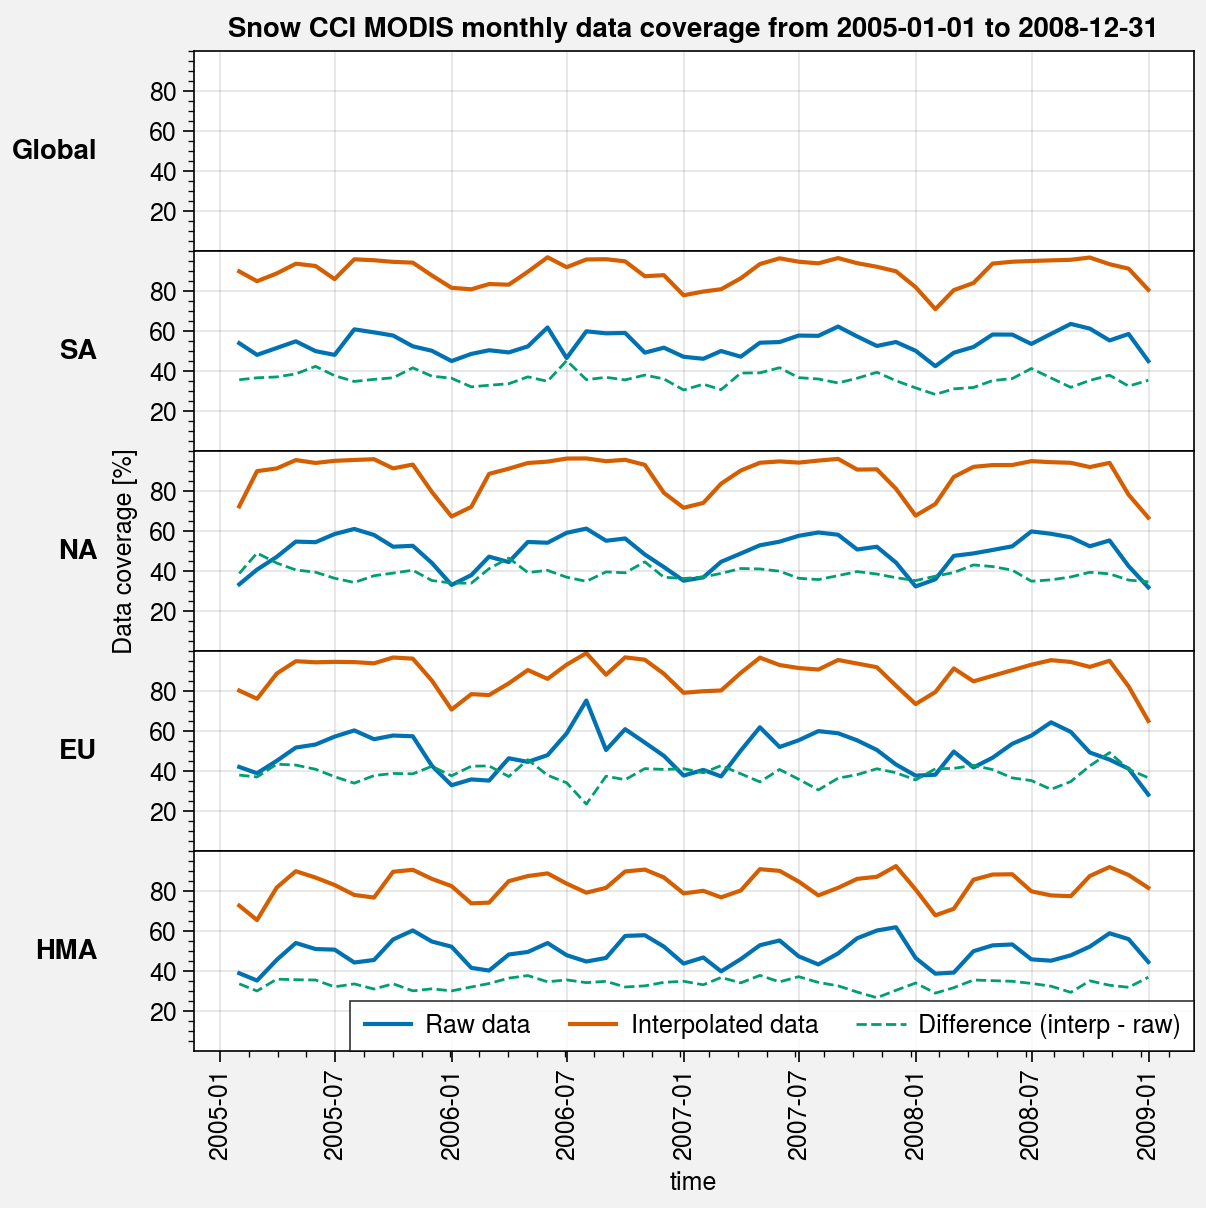

In [7]:
fig, axs = plot.subplots(nrows=5, aspect=5, axwidth=5, space=0)

# axs[0].plot(ts_coverage)
# axs[0].plot(ts_coverage_interp)
# axs[0].plot(ts_coverage_interp - ts_coverage, lw=1, ls='--')

axs[1].plot(ts_coverage_SA)
axs[1].plot(ts_coverage_interp_SA)
axs[1].plot(ts_coverage_interp_SA - ts_coverage_SA, lw=1, ls='--')

axs[2].plot(ts_coverage_US)
axs[2].plot(ts_coverage_interp_US)
axs[2].plot(ts_coverage_interp_US - ts_coverage_US, lw=1, ls='--')

axs[3].plot(ts_coverage_EU)
axs[3].plot(ts_coverage_interp_EU)
axs[3].plot(ts_coverage_interp_EU - ts_coverage_EU, lw=1, ls='--')

axs[4].plot(ts_coverage_HMA, label='Raw data')
axs[4].plot(ts_coverage_interp_HMA, label='Interpolated data')
axs[4].plot(ts_coverage_interp_HMA - ts_coverage_HMA, lw=1, ls='--', label='Difference (interp - raw)')
axs[4].legend(loc='lr')

axs.format(
    ylim=(0,100), yticks=[20, 40, 60, 80], ylabel='Data coverage [%]',
    suptitle='Snow CCI MODIS monthly data coverage from '+str(pd.to_datetime(period.start))[:10]+ ' to '+str(ds.time[-1].values)[:10],
    rowlabels=['Global', 'SA', 'NA', 'EU', 'HMA'],
)
    
fig.save('img/snowCCI_MODIS_monthly_coverage_'+str(pd.to_datetime(period.start))[:10]+'_'+str(ds.time[-1].values)[:10]+'.jpg')  